In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

from collections import Counter

from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

import tensorflow as tf
import time

In [ ]:
df_fridge = pd.read_csv("/content/drive/MyDrive/Threat Detection in IoT Devices using FL _ CDL /Dataset/IoT_Fridge.csv")
df_gps_tracker = pd.read_csv("/content/drive/MyDrive/Threat Detection in IoT Devices using FL _ CDL /Dataset/IoT_GPS_Tracker.csv")
df_garage_door = pd.read_csv("/content/drive/MyDrive/Threat Detection in IoT Devices using FL _ CDL /Dataset/IoT_Garage_Door.csv", low_memory=False)
df_modbus = pd.read_csv("/content/drive/MyDrive/Threat Detection in IoT Devices using FL _ CDL /Dataset/IoT_Modbus.csv")
df_motion_light = pd.read_csv("/content/drive/MyDrive/Threat Detection in IoT Devices using FL _ CDL /Dataset/IoT_Motion_Light.csv")
df_thermostat = pd.read_csv("/content/drive/MyDrive/Threat Detection in IoT Devices using FL _ CDL /Dataset/IoT_Thermostat.csv")
df_weather = pd.read_csv("/content/drive/MyDrive/Threat Detection in IoT Devices using FL _ CDL /Dataset/IoT_Weather.csv")

In [ ]:
all_df = [df_fridge, df_gps_tracker, df_garage_door, df_modbus, df_motion_light, df_thermostat, df_weather]

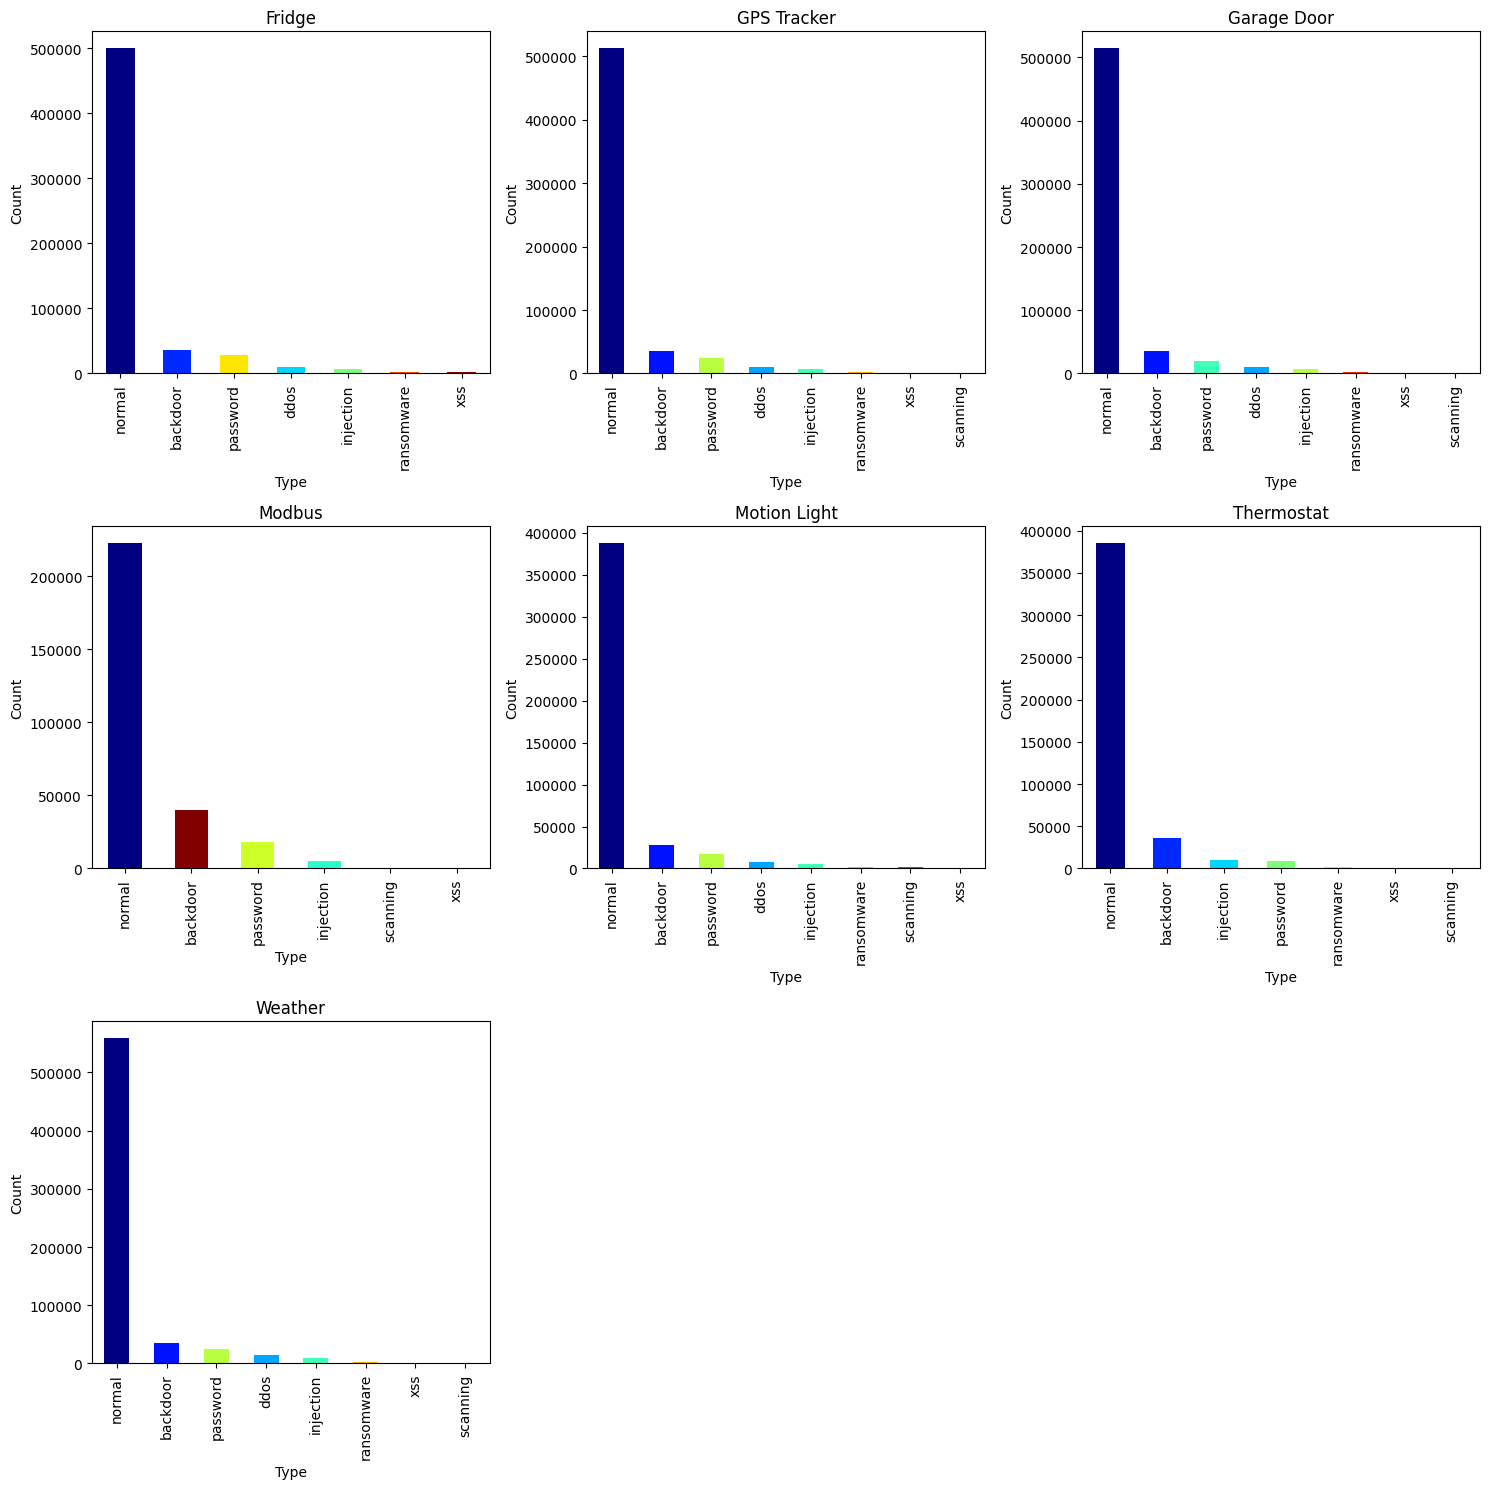

In [ ]:
labels = ['Fridge', 'GPS Tracker', 'Garage Door', 'Modbus', 'Motion Light', 'Thermostat', 'Weather']

fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))

for idx, df in enumerate(all_df):
    row = idx // 3
    col = idx % 3
    unique_types = df['type'].unique()
    colors = plt.cm.jet(np.linspace(0, 1, len(unique_types)))
    color_map = dict(zip(unique_types, colors))
    df['type'].value_counts().plot(kind='bar', ax=axs[row, col], title=labels[idx], color=[color_map[type_val] for type_val in df['type'].value_counts().index])
    axs[row, col].set_ylabel('Count')
    axs[row, col].set_xlabel('Type')

# Removing empty subplots
for idx in range(len(all_df), 9):
    row = idx // 3
    col = idx % 3
    fig.delaxes(axs[row][col])

plt.tight_layout()
plt.show()


# Preprocessing

In [ ]:
for device in all_df:
  # Combine 'date' and 'time' and convert to datetime object
  device['datetime'] = pd.to_datetime(device['date'] + ' ' + device['time'])

  # Drop the original 'date' and 'time' columns
  device.drop(['date', 'time'], axis=1, inplace=True)


/var/folders/_d/nb75wxbd61517k8wfh2v9kr80000gn/T/ipykernel_30094/1991897485.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  device['datetime'] = pd.to_datetime(device['date'] + ' ' + device['time'])
/var/folders/_d/nb75wxbd61517k8wfh2v9kr80000gn/T/ipykernel_30094/1991897485.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  device['datetime'] = pd.to_datetime(device['date'] + ' ' + device['time'])
/var/folders/_d/nb75wxbd61517k8wfh2v9kr80000gn/T/ipykernel_30094/1991897485.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  device['datetime'] = pd.to_datetime(device['da

In [ ]:
# dropping the label since we want to do a multi-class classification
for device in all_df:
    device.drop(['label'], axis=1, inplace=True)

In [ ]:
# Clean the 'temp_condition' column
df_fridge['temp_condition'] = df_fridge['temp_condition'].str.strip()
df_fridge['temp_condition'] = df_fridge['temp_condition'].str.replace(' +', ' ')

In [ ]:
# dropping null values in respective dataframes
df_garage_door.dropna(inplace=True)
df_thermostat.dropna(inplace=True)

In [ ]:
# Convert all values to strings
df_garage_door['sphone_signal'] = df_garage_door['sphone_signal'].astype(str)

# Strip leading and trailing spaces
df_garage_door['sphone_signal'] = df_garage_door['sphone_signal'].str.strip()

# Replace 'false' and 'true' with 0 and 1 respectively
df_garage_door['sphone_signal'] = df_garage_door['sphone_signal'].replace({'false': 0, 'true': 1, '0.0': 0, '1.0': 1, '0': 0, '1': 1})

In [ ]:
# Strip leading and trailing spaces
df_motion_light['light_status'] = df_motion_light['light_status'].str.strip()

In [ ]:
# label encoding each class in all dataframes

# Global Label Encoder
all_labels = np.concatenate([df['type'] for df in all_df])  # concatenate all labels
global_encoder = LabelEncoder().fit(all_labels)  # fit the encoder

# We do this so that all labels across each dataframe has the encoding
for df in all_df:
    df['type'] = global_encoder.transform(df['type'])  # transform the labels

In [ ]:
df_garage_door = pd.get_dummies(df_garage_door, columns=['door_state'])
df_fridge = pd.get_dummies(df_fridge, columns=['temp_condition'])
df_motion_light = pd.get_dummies(df_motion_light, columns = ['light_status'])

for n, df in enumerate(all_df):
    if 'door_state' in df.columns:
        all_df[n] = df_garage_door
    elif 'temp_condition' in df.columns:
        all_df[n] = df_fridge
    elif 'light_status' in df.columns:
      all_df[n] = df_motion_light

In [ ]:
def process_datetime(df):
    df['hour'] = df['datetime'].dt.hour
    df['day_of_week'] = df['datetime'].dt.dayofweek
    df['is_weekend'] = (df['datetime'].dt.weekday >= 5).astype(int)
    df.drop(columns=['datetime'], axis=1, inplace=True)
    return df

df_final = [process_datetime(df.copy()) for df in [df_fridge, df_gps_tracker, df_garage_door, df_modbus, df_motion_light, df_thermostat, df_weather]]

In [ ]:
for df in df_final:
    df = df.astype(float)

In [ ]:
# Define a function to standardize numerical columns
def standardize_data(df, numerical_cols):
    scaler = StandardScaler()
    for col in numerical_cols:
        if col in df.columns:
            df[col] = scaler.fit_transform(df[[col]])
    return df

numerical_cols = ['fridge_temperature', 'latitude', 'longitude', 'FC1_Read_Input_Register',
                  'FC2_Read_Discrete_Value', 'FC3_Read_Holding_Register', 'FC4_Read_Coil',
                  'current_temperature', 'temperature', 'pressure', 'humidity', 'hour']

# Create a new list to hold the standardized DataFrames
df_final_standardized = []

# Iterate over each DataFrame in df_federated
for df in df_final:
    df_standardized = standardize_data(df, numerical_cols)
    df_final_standardized.append(df_standardized)


In [ ]:
from sklearn.decomposition import PCA

# Assuming df_final_standardized is loaded and contains the dataframes in the order you mentioned.
dataframes = {
    "df_fridge": df_final_standardized[0],
    "df_gps_tracker": df_final_standardized[1],
    "df_garage_door": df_final_standardized[2],
    "df_modbus": df_final_standardized[3],
    "df_motion_light": df_final_standardized[4],
    "df_thermostat": df_final_standardized[5],
    "df_weather": df_final_standardized[6]
}

reduced_data = {}

for name, df in dataframes.items():
    pca = PCA(n_components=5)
    X_reduced = pca.fit_transform(df.drop(columns=["type"]))
    # print(X_reduced.explained_variance_ratio_)
    reduced_df = pd.DataFrame(X_reduced)
    reduced_df["type"] = df["type"].values
    reduced_data[name] = reduced_df

In [ ]:
# Merge all dataframes
merged_df = pd.concat(reduced_data.values(), ignore_index=True)

# Centralized Deep Learning

## All Sample CDL (Feedforward Neural Network)

In [ ]:
# Separate features and target
X_all = merged_df.drop('type', axis=1)
y_all = merged_df['type']

# One-hot encode the labels
one_hot = OneHotEncoder(sparse_output=False)
y_all = one_hot.fit_transform(y_all.values.reshape(-1, 1))

# Split the data into training, validation, and test sets
X_all_train, X_all_temp, y_all_train, y_all_temp = train_test_split(X_all, y_all, test_size=0.3, random_state=42)
X_all_val, X_all_test, y_all_val, y_all_test = train_test_split(X_all_temp, y_all_temp, test_size=0.5, random_state=42)


In [ ]:
# Create the model
model_all = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_all_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(y_all.shape[1], activation='softmax')  # number of classes
])

# Compile the model
model_all.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=[
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
        'accuracy'
    ]
)

epoch_durations = []
all_train_loss = []
all_val_loss = []
all_train_accuracy = []
all_val_accuracy = []

# Train the model
for epoch in range(10):  # number of epochs
    start_time = time.time()
    history = model_all.fit(
        X_all_train, y_all_train,
        validation_data=(X_all_val, y_all_val),
        epochs=1, batch_size=32, verbose=2  # train for one epoch at a time
    )
    end_time = time.time()

    # Accumulate the loss and accuracy values
    all_train_loss.extend(history.history['loss'])
    all_val_loss.extend(history.history['val_loss'])
    all_train_accuracy.extend(history.history['accuracy'])
    all_val_accuracy.extend(history.history['val_accuracy'])

    epoch_durations.append(end_time - start_time)


# Evaluate the model
results = model_all.evaluate(X_all_test, y_all_test, verbose=0)
print("===========================")
print("For All Sample in CDL")
print(f"Test Loss: {results[0]}")
print(f"Test Precision: {results[1]}")
print(f"Test Recall: {results[2]}")
print(f"Test Accuracy: {results[3]}")
print(f"Test F1 Score: {2 * (results[1] * results[2]) / (results[1] + results[2])}")


# Plotting the training and validation loss and accuracy
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.plot(all_train_loss, label='Training Loss')
plt.plot(all_val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss - All Sample')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(all_train_accuracy, label='Training Accuracy')
plt.plot(all_val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy - All Sample')
plt.legend()

# Plotting the average running time of each epoch
plt.subplot(1, 3, 3)
plt.plot(epoch_durations, label='Epoch Duration')
plt.xlabel('Epochs')
plt.ylabel('Duration (seconds)')
plt.title('Average Running Time of Each Epoch - All Sample')
plt.legend()

plt.tight_layout()
plt.show()


## Undersampled CDL (Feedforward Neural Network)

In [ ]:
# Function to undersample the majority class in a dataframe
def undersample(df, target_column):
    # Split the dataframe by class
    df_majority = df[df[target_column] == 3]
    df_minority = df[df[target_column] != 3]

    # Downsample the majority class
    df_majority_downsampled = resample(df_majority,
                                       replace=False,
                                       n_samples=len(df_minority),
                                       random_state=42)

    # Combine the downsampled majority class dataframe with the original minority class dataframe
    df_downsampled = pd.concat([df_majority_downsampled, df_minority])

    return df_downsampled

# Apply the undersample function to each dataframe
df_undersampled = undersample(merged_df, 'type')

In [ ]:
# Separate features and target
X_under = df_undersampled.drop('type', axis=1)
y_under = df_undersampled['type']

# One-hot encode the labels
one_hot = OneHotEncoder(sparse_output=False)
y_under = one_hot.fit_transform(y_under.values.reshape(-1, 1))

# Split the data into training, validation, and test sets
X_under_train, X_under_temp, y_under_train, y_under_temp = train_test_split(X_under, y_under, test_size=0.3, random_state=42)
X_under_val, X_under_test, y_under_val, y_under_test = train_test_split(X_under_temp, y_under_temp, test_size=0.5, random_state=42)


22714/22714 - 9s - loss: 0.2773 - precision_12: 0.9021 - recall_12: 0.8794 - val_loss: 0.2064 - val_precision_12: 0.9253 - val_recall_12: 0.9176 - 9s/epoch - 402us/step
22714/22714 - 10s - loss: 0.1930 - precision_12: 0.9279 - recall_12: 0.9216 - val_loss: 0.1770 - val_precision_12: 0.9327 - val_recall_12: 0.9275 - 10s/epoch - 423us/step
22714/22714 - 9s - loss: 0.1696 - precision_12: 0.9374 - recall_12: 0.9334 - val_loss: 0.1685 - val_precision_12: 0.9426 - val_recall_12: 0.9385 - 9s/epoch - 413us/step
22714/22714 - 9s - loss: 0.1577 - precision_12: 0.9430 - recall_12: 0.9402 - val_loss: 0.1652 - val_precision_12: 0.9379 - val_recall_12: 0.9350 - 9s/epoch - 409us/step
22714/22714 - 9s - loss: 0.1501 - precision_12: 0.9463 - recall_12: 0.9441 - val_loss: 0.1395 - val_precision_12: 0.9519 - val_recall_12: 0.9494 - 9s/epoch - 399us/step
22714/22714 - 9s - loss: 0.1446 - precision_12: 0.9484 - recall_12: 0.9465 - val_loss: 0.1362 - val_precision_12: 0.9534 - val_recall_12: 0.9516 - 9s/epo

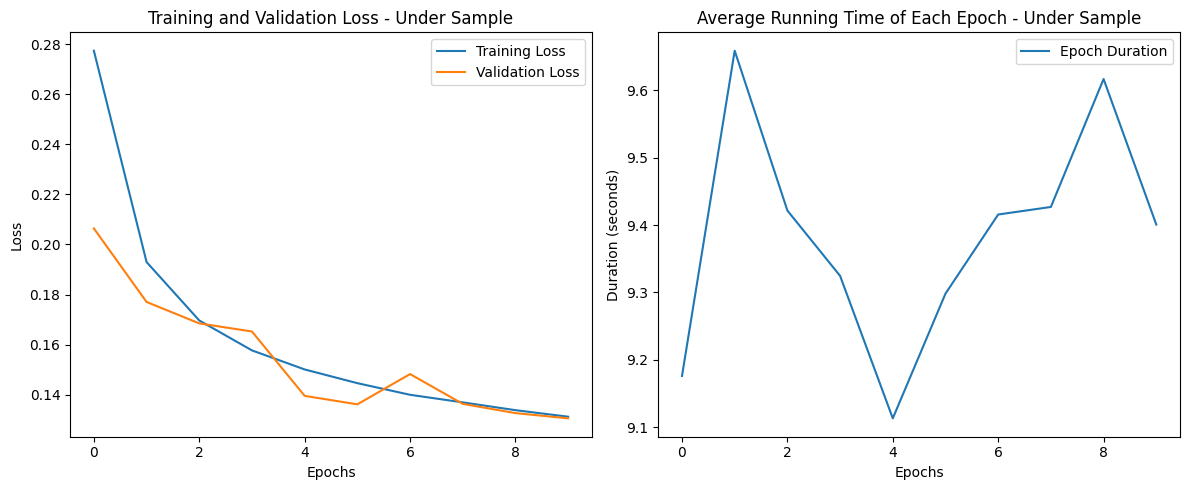

In [ ]:
# Create the model
model_under = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_under_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(y_under.shape[1], activation='softmax')  # number of classes
])

# Compile the model
model_under.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

epoch_durations = []
under_train_loss = []
under_val_loss = []

# Train the model
for epoch in range(10):  # number of epochs
    start_time = time.time()
    history = model_under.fit(
        X_under_train, y_under_train,
        validation_data=(X_under_val, y_under_val),
        epochs=1, batch_size=32, verbose=2  # train for one epoch at a time
    )
    end_time = time.time()

    # Accumulate the loss values
    under_train_loss.extend(history.history['loss'])
    under_val_loss.extend(history.history['val_loss'])

    epoch_durations.append(end_time - start_time)


# Evaluate the model
results = model_under.evaluate(X_under_test, y_under_test, verbose=0)

print("===========================")
print("For Undersampled in CDL")
print(f"Test Loss: {results[0]}")
print(f"Test Precision: {results[1]}")
print(f"Test Recall: {results[2]}")
print(f"Test F1 Score: {2 * (results[1] * results[2]) / (results[1] + results[2])}")


# Plotting the training and validation loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(under_train_loss, label='Training Loss')
plt.plot(under_val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss - Under Sample')
plt.legend()

# Plotting the average running time of each epoch
plt.subplot(1, 2, 2)
plt.plot(epoch_durations, label='Epoch Duration')
plt.xlabel('Epochs')
plt.ylabel('Duration (seconds)')
plt.title('Average Running Time of Each Epoch - Under Sample')
plt.legend()

plt.tight_layout()
plt.show()


## Oversample & Undersample (Feedforward Neural Network)

In [ ]:
print('Original dataset shape %s' % Counter(merged_df['type']))

In [ ]:
# Define oversampling and undersampling methods

# For class 3, it should represent 50% of the total data.
# Since the total number of samples is 3552244, we want approximately 1776122 samples in class 3 after resampling.
# For the other classes, we want them to sum up to 50% of the data.
# To keep things simple, let's distribute this equally among the 7 classes. So each of these classes will have about 253128 samples.

over = SMOTE(sampling_strategy={0: 253128, 4: 253128, 1: 253128, 2: 253128, 5: 253128, 7: 253128, 6: 253128})
under = RandomUnderSampler(sampling_strategy={3: 1776122})

# Define pipeline
pipeline = Pipeline(steps=[('o', over), ('u', under)])

# Separate features and target
X = merged_df.drop('type', axis=1)
y = merged_df['type']

# Apply the resampling
X_resampled, y_resampled = pipeline.fit_resample(X, y)


# One-hot encode the labels
one_hot = OneHotEncoder(sparse_output=False)
y_resampled = one_hot.fit_transform(y_resampled.values.reshape(-1, 1))

In [ ]:
# Split the data into training, validation, and test sets
X_resampled_train, X_resampled_temp, y_resampled_train, y_resampled_temp = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)
X_resampled_val, X_resampled_test, y_resampled_val, y_resampled_test = train_test_split(X_resampled_temp, y_resampled_temp, test_size=0.5, random_state=42)

In [ ]:
# Create the model
model_resampled = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_resampled_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(y_resampled.shape[1], activation='softmax')  # number of classes
])

# Compile the model
model_resampled.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

epoch_durations = []
re_train_loss = []
re_val_loss = []

# Train the model
for epoch in range(10):  # number of epochs
    start_time = time.time()
    history = model_resampled.fit(
        X_resampled_train, y_resampled_train,
        validation_data=(X_resampled_val, y_resampled_val),
        epochs=1, batch_size=32, verbose=2  # train for one epoch at a time
    )
    end_time = time.time()

    # Accumulate the loss values
    re_train_loss.extend(history.history['loss'])
    re_val_loss.extend(history.history['val_loss'])

    epoch_durations.append(end_time - start_time)

# Evaluate the model
results = model_resampled.evaluate(X_resampled_test, y_resampled_test, verbose=0)

print("===========================")
print("For Resampled - (Over & Under) in CDL")
print(f"Test Loss: {results[0]}")
print(f"Test Precision: {results[1]}")
print(f"Test Recall: {results[2]}")
print(f"Test F1 Score: {2 * (results[1] * results[2]) / (results[1] + results[2])}")



# Plotting the training and validation loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(re_train_loss, label='Training Loss')
plt.plot(re_val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss - ReSample')
plt.legend()

# Plotting the average running time of each epoch
plt.subplot(1, 2, 2)
plt.plot(epoch_durations, label='Epoch Duration')
plt.xlabel('Epochs')
plt.ylabel('Duration (seconds)')
plt.title('Average Running Time of Each Epoch - ReSample')
plt.legend()

plt.tight_layout()
plt.show()
